# Анализа на демографски животни табели

In [43]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [45]:
df_sweden = pd.read_csv(
    'datasets/bltper_1x1.csv',
    sep='\s+',           
    skiprows=1,
    header=None,
    names=['Year','Age','mx','qx','ax','lx','dx','Lx','Tx','ex']
)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/2y/hylb1v1n55b2675rzdhyt2b00000gn/T/ipykernel_3900/3165724944.py:3: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',


Rows with Age == 0: 274


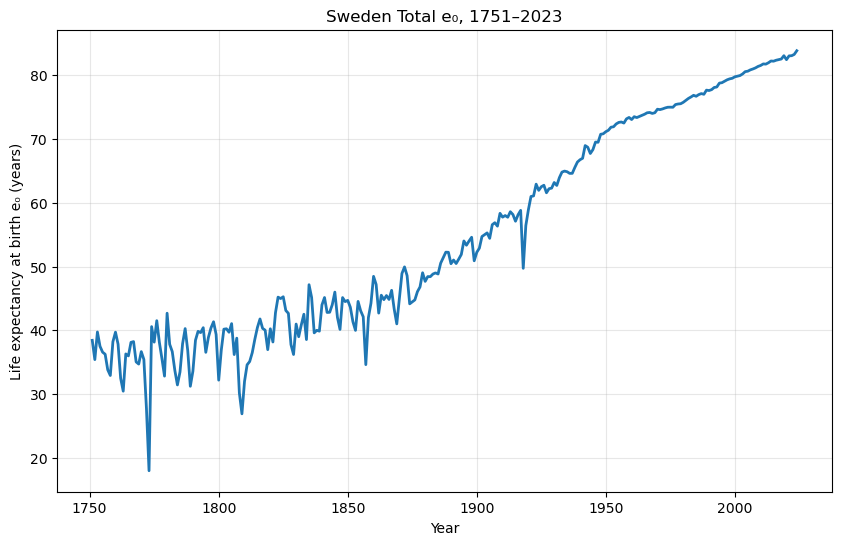

In [47]:
import pandas as pd

df_sweden['Age'] = df_sweden['Age'].replace({'110+': '110'}).astype(int)

e0 = df_sweden[df_sweden['Age'] == 0]

print("Rows with Age == 0:", e0.shape[0]) # ako e 273 e ok

plt.figure(figsize=(10,6))
plt.plot(e0['Year'], e0['ex'], lw=2)
plt.xlabel("Year")
plt.ylabel("Life expectancy at birth e₀ (years)")
plt.title("Sweden Total e₀, 1751–2023")
plt.grid(alpha=0.3)
plt.show()


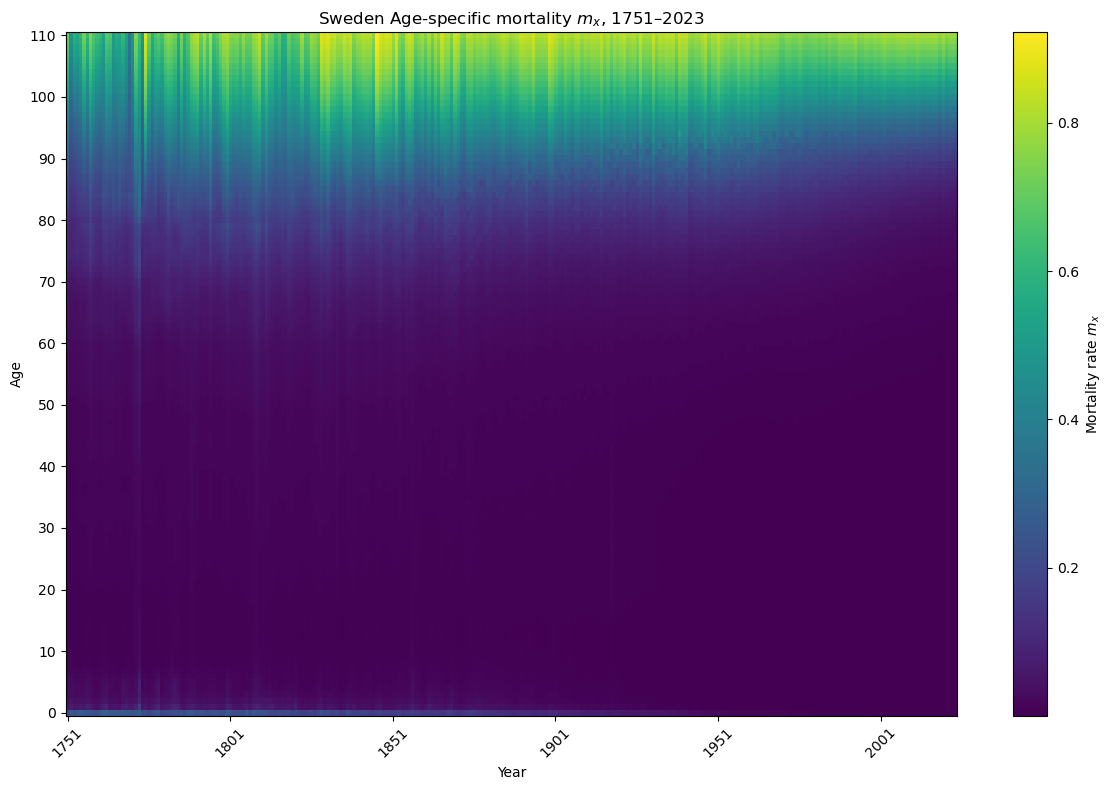

In [53]:
pivot_mx = df_sweden.pivot(index='Age', columns='Year', values='mx')

plt.figure(figsize=(12, 8))
im = plt.imshow(
    pivot_mx, 
    origin='lower',         # so Age 0 sits at the bottom of the vertical axis
    aspect='auto',          
    interpolation='nearest' 
)
cbar = plt.colorbar(im)
cbar.set_label('Mortality rate $m_x$')

plt.xlabel('Year')
plt.ylabel('Age')
plt.title('Sweden Age‐specific mortality $m_x$, 1751–2023')

years = pivot_mx.columns
ages  = pivot_mx.index

year_ticks = list(range(years.min(), years.max()+1, 50))
year_positions = [list(years).index(y) for y in year_ticks if y in years]
plt.xticks(year_positions, year_ticks, rotation=45)

age_ticks = list(range(0, ages.max()+1, 10))
age_positions = [list(ages).index(a) for a in age_ticks if a in ages]
plt.yticks(age_positions, age_ticks)

plt.tight_layout()
plt.savefig('sweden_age_specific_mortality_mx.png')
plt.show()

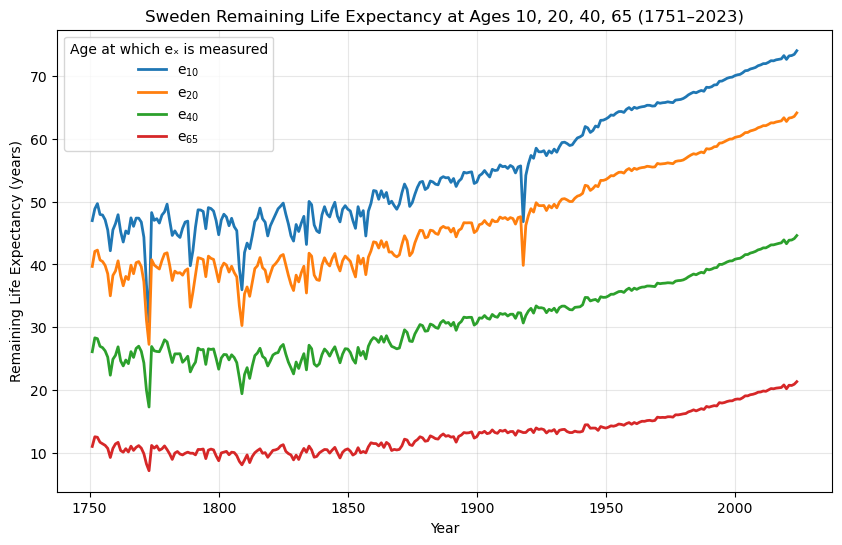

In [55]:
selected_ages = [10, 20, 40, 65]
subset = df_sweden[df_sweden['Age'].isin(selected_ages)]

pivoted = subset.pivot(index='Year', columns='Age', values='ex')

plt.figure(figsize=(10, 6))
for age in selected_ages:
    plt.plot(pivoted.index, pivoted[age], lw=2, label=f'e$_{{{age}}}$')

plt.title("Sweden Remaining Life Expectancy at Ages 10, 20, 40, 65 (1751–2023)")
plt.xlabel("Year")
plt.ylabel("Remaining Life Expectancy (years)")
plt.grid(alpha=0.3)
plt.legend(title="Age at which eₓ is measured")
plt.show()

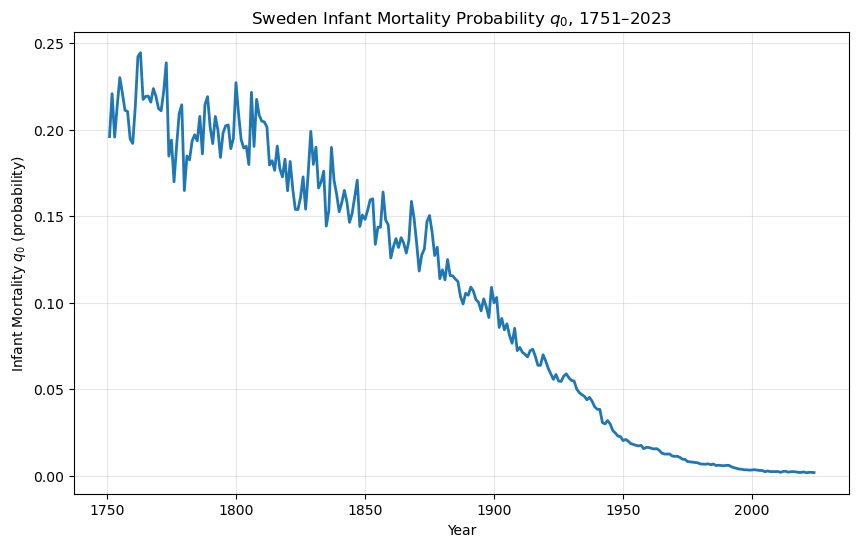

In [59]:
infants = df_sweden[df_sweden['Age'] == 0]

# q0 - verojatnosata
plt.figure(figsize=(10, 6))
plt.plot(infants['Year'], infants['qx'], lw=2, color='tab:blue')
plt.title("Sweden Infant Mortality Probability $q_0$, 1751–2023")
plt.xlabel("Year")
plt.ylabel("Infant Mortality $q_0$ (probability)")
plt.grid(alpha=0.3)

plt.show()

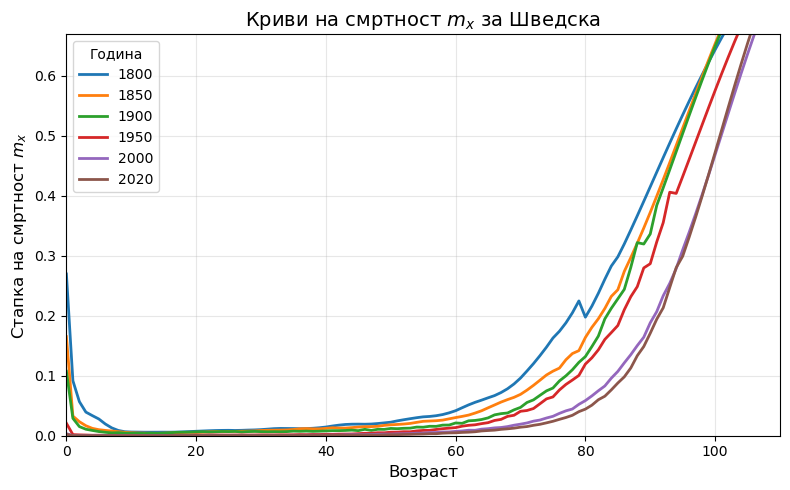

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def plot_hazard_curves(df, years, title, filename):
    plt.figure(figsize=(8, 5))
    for year in years:
        subset = df[df['Year'] == year].copy()
        if subset.empty:
            continue
        subset = subset.sort_values('Age')
        plt.plot(
            subset['Age'],
            subset['mx'],
            label=str(year),
            linewidth=2
        )

    plt.xlabel('Возраст', fontsize=12)
    plt.ylabel('Стапка на смртност $m_x$', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(title='Година')
    plt.grid(alpha=0.3)
    # Ограничување на y-оската за читаемост
    ymax = np.percentile(df['mx'], 95)
    plt.ylim(0, ymax)
    plt.xlim(0, df['Age'].max())
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

years_sel = [1800, 1850, 1900, 1950, 2000, 2020]

# hazard curves (mₓ)
plot_hazard_curves(
    df_sweden,
    years_sel,
    'Криви на смртност $m_x$ за Шведска',
    'sweden_hazard_curves.png'
)




In [27]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.


| Model    |   Parameters (p) |       RMSE |       R2 |      AIC |
|:---------|-----------------:|-----------:|---------:|---------:|
| Gompertz |                2 | 0.00710002 | 0.969975 | -500.661 |
| Weibull  |                2 | 0.00233462 | 0.996754 | -614.11  |


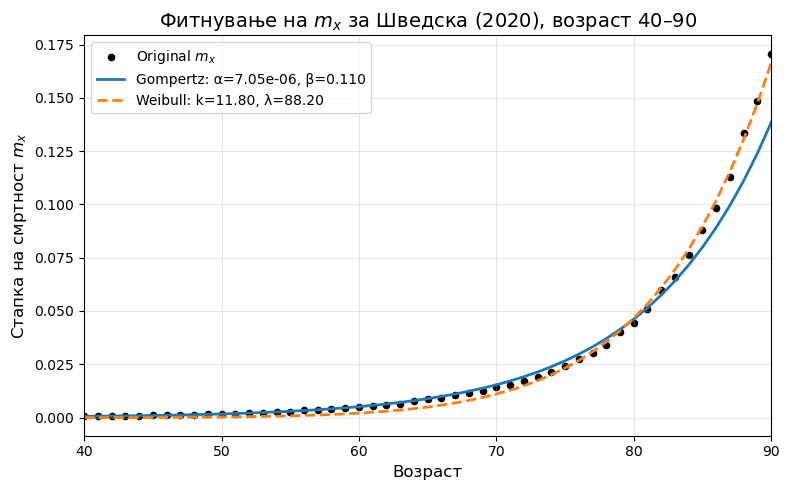

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# metrics 
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def aic(y_true, y_pred, p):
    n = len(y_true)
    rss = np.sum((y_true - y_pred) ** 2)
    return 2 * p + n * np.log(rss / n)

# fitting functions
def fit_gompertz(ages, mx_vals):
    coeffs = np.polyfit(ages, np.log(mx_vals), 1)
    beta = coeffs[0]
    alpha = np.exp(coeffs[1])
    m_fit = alpha * np.exp(beta * ages)
    return alpha, beta, m_fit

def fit_weibull(ages, mx_vals):
    def obj(params, x, m_obs):
        k, lam = params
        m_pred = (k / lam) * ((x / lam) ** (k - 1))
        return np.sum((m_obs - m_pred) ** 2)
    init = [5.0, 80.0]
    bounds = [(0.1, 20.0), (30.0, 200.0)]
    res = minimize(obj, x0=init, args=(ages, mx_vals), bounds=bounds)
    k_opt, lam_opt = res.x
    m_fit = (k_opt / lam_opt) * ((ages / lam_opt) ** (k_opt - 1))
    return k_opt, lam_opt, m_fit

# extract ages and mx for 2020, ages 40-90
year = 2020
subset = df_sweden[df_sweden['Year'] == year].sort_values('Age')
subset_fit = subset[(subset['Age'] >= 40) & (subset['Age'] <= 90)]
ages = subset_fit['Age'].values
mx_vals = subset_fit['mx'].values

alpha_gom, beta_gom, gomfit = fit_gompertz(ages, mx_vals)
k_weib, lam_weib, weibit = fit_weibull(ages, mx_vals)

metrics = []
for name, pred in [('Gompertz', gomfit), ('Weibull', weibit)]:
    metrics.append({
        'Model': name,
        'Parameters (p)': 2,
        'RMSE': rmse(mx_vals, pred),
        'R2': r2_score(mx_vals, pred),
        'AIC': aic(mx_vals, pred, p=2)
    })
metrics_df = pd.DataFrame(metrics)

print(metrics_df.to_markdown(index=False))

plt.figure(figsize=(8, 5))
plt.scatter(ages, mx_vals, label='Original $m_x$', color='black', s=20)
plt.plot(ages, gomfit, label=f'Gompertz: α={alpha_gom:.2e}, β={beta_gom:.3f}', linewidth=2)
plt.plot(ages, weibit, label=f'Weibull: k={k_weib:.2f}, λ={lam_weib:.2f}', linewidth=2, linestyle='--')
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Стапка на смртност $m_x$', fontsize=12)
plt.title(f'Фитнување на $m_x$ за Шведска ({year}), возраст 40–90', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(40, 90)
plt.tight_layout()
plt.show()

In [69]:
import pandas as pd

df_swed_males = pd.read_csv(
    "datasets/males_1x1.csv",
    sep=r"\s+",
    skiprows=1,
    header=None,
    names=["Year","Age","mx","qx","ax","lx","dx","Lx","Tx","ex"]
)
df_swed_males

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
0,1751,0,0.24110,0.20625,0.30,100000,20625,85545,3686513,36.87
1,1751,1,0.05295,0.05158,0.50,79375,4094,77328,3600969,45.37
2,1751,2,0.03459,0.03400,0.50,75280,2559,74001,3523641,46.81
3,1751,3,0.02788,0.02750,0.50,72721,2000,71721,3449640,47.44
4,1751,4,0.02569,0.02537,0.50,70721,1794,69824,3377919,47.76
...,...,...,...,...,...,...,...,...,...,...
30409,2024,106,0.70448,0.52097,0.50,39,20,29,54,1.37
30410,2024,107,0.73547,0.53773,0.50,19,10,14,25,1.32
30411,2024,108,0.76430,0.55298,0.50,9,5,6,11,1.28
30412,2024,109,0.79088,0.56676,0.50,4,2,3,5,1.25


In [71]:
df_swed_fem = pd.read_csv(
    "datasets/females_1x1.csv",
    sep=r"\s+",
    skiprows=1,
    header=None,
    names=["Year","Age","mx","qx","ax","lx","dx","Lx","Tx","ex"]
)
df_swed_fem

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
0,1751,0,0.21223,0.18527,0.31,100000,18527,87293,3992904,39.93
1,1751,1,0.04941,0.04822,0.50,81473,3929,79509,3905611,47.94
2,1751,2,0.03225,0.03174,0.50,77545,2461,76314,3826102,49.34
3,1751,3,0.02601,0.02567,0.50,75084,1928,74120,3749788,49.94
4,1751,4,0.02370,0.02342,0.50,73156,1713,72300,3675668,50.24
...,...,...,...,...,...,...,...,...,...,...
30409,2024,106,0.64232,0.48618,0.50,154,75,116,229,1.49
30410,2024,107,0.67713,0.50586,0.50,79,40,59,112,1.42
30411,2024,108,0.71008,0.52403,0.50,39,20,29,53,1.37
30412,2024,109,0.74096,0.54066,0.50,19,10,14,25,1.33


In [73]:
df_swed_males["Sex"]="Male"
df_swed_fem["Sex"]="Female"
df_swed_both=pd.concat([df_swed_males, df_swed_fem], ignore_index=True)
df_swed_both

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex,Sex
0,1751,0,0.24110,0.20625,0.3,100000,20625,85545,3686513,36.87,Male
1,1751,1,0.05295,0.05158,0.5,79375,4094,77328,3600969,45.37,Male
2,1751,2,0.03459,0.03400,0.5,75280,2559,74001,3523641,46.81,Male
3,1751,3,0.02788,0.02750,0.5,72721,2000,71721,3449640,47.44,Male
4,1751,4,0.02569,0.02537,0.5,70721,1794,69824,3377919,47.76,Male
...,...,...,...,...,...,...,...,...,...,...,...
60823,2024,106,0.64232,0.48618,0.5,154,75,116,229,1.49,Female
60824,2024,107,0.67713,0.50586,0.5,79,40,59,112,1.42,Female
60825,2024,108,0.71008,0.52403,0.5,39,20,29,53,1.37,Female
60826,2024,109,0.74096,0.54066,0.5,19,10,14,25,1.33,Female


In [75]:
df_swed_both = df_swed_both[df_swed_both["Age"] != "110+"].copy()

for col in ["mx","qx","ax","lx","dx","Lx","Tx","ex"]:
    df_swed_both[col] = pd.to_numeric(df_swed_both[col].replace(".", pd.NA), errors="coerce")

df_swed_both = df_swed_both.dropna(subset=["Age","mx","lx"])

df_swed_both["Age"] = df_swed_both["Age"].astype(int)
df_swed_both["Year"] = df_swed_both["Year"].astype(int)
df_swed_both

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex,Sex
0,1751,0,0.24110,0.20625,0.3,100000,20625,85545,3686513,36.87,Male
1,1751,1,0.05295,0.05158,0.5,79375,4094,77328,3600969,45.37,Male
2,1751,2,0.03459,0.03400,0.5,75280,2559,74001,3523641,46.81,Male
3,1751,3,0.02788,0.02750,0.5,72721,2000,71721,3449640,47.44,Male
4,1751,4,0.02569,0.02537,0.5,70721,1794,69824,3377919,47.76,Male
...,...,...,...,...,...,...,...,...,...,...,...
60822,2024,105,0.60594,0.46504,0.5,287,133,220,449,1.56,Female
60823,2024,106,0.64232,0.48618,0.5,154,75,116,229,1.49,Female
60824,2024,107,0.67713,0.50586,0.5,79,40,59,112,1.42,Female
60825,2024,108,0.71008,0.52403,0.5,39,20,29,53,1.37,Female


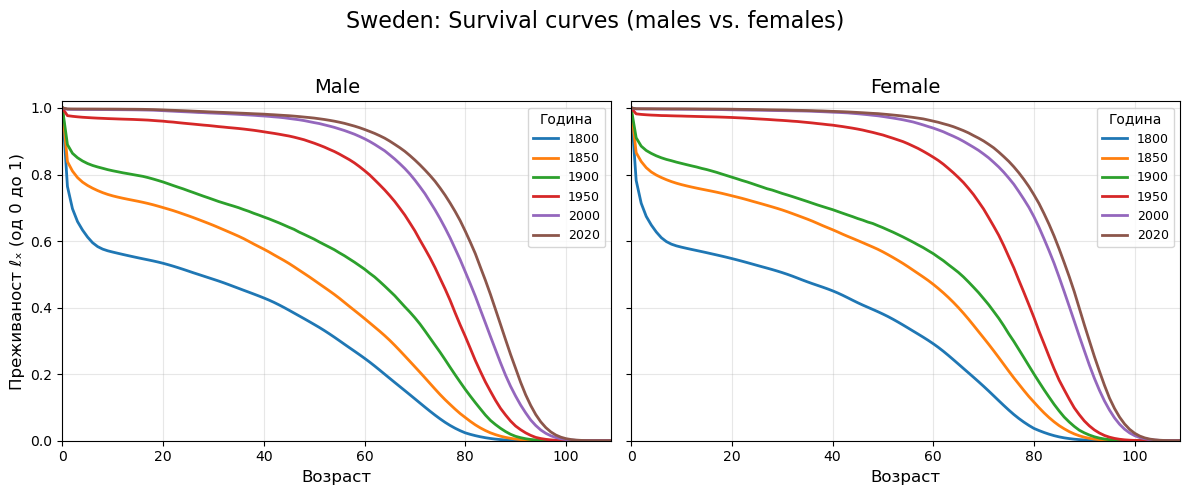

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for (sex, ax) in [("Male", axes[0]), ("Female", axes[1])]:
    for year in years_sel:
        subset = df_swed_both[
            (df_swed_both["Sex"] == sex) & (df_swed_both["Year"] == year)
        ].sort_values("Age")
        if subset.empty:
            continue
            
        l0 = subset.loc[subset["Age"] == 0, "lx"].iloc[0]
        subset["lx_frac"] = subset["lx"] / l0

        ax.plot(
            subset["Age"],
            subset["lx_frac"],
            label=str(year),
            linewidth=2
        )
    ax.set_xlabel("Возраст", fontsize=12)
    ax.set_title(f"{sex}", fontsize=14)
    if sex == "Male":
        ax.set_ylabel("Преживаност ℓₓ (од 0 до 1)", fontsize=12)
    ax.legend(title="Година", fontsize=9, title_fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1.02)
    ax.set_xlim(0, df_swed_both["Age"].max())

fig.suptitle("Sweden: Survival curves (males vs. females)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig("sweden_surv_m_vs_f.png")
plt.show()

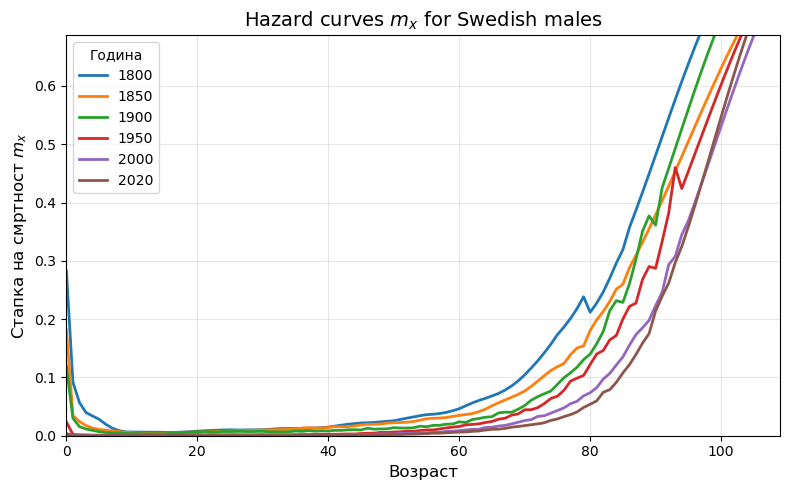

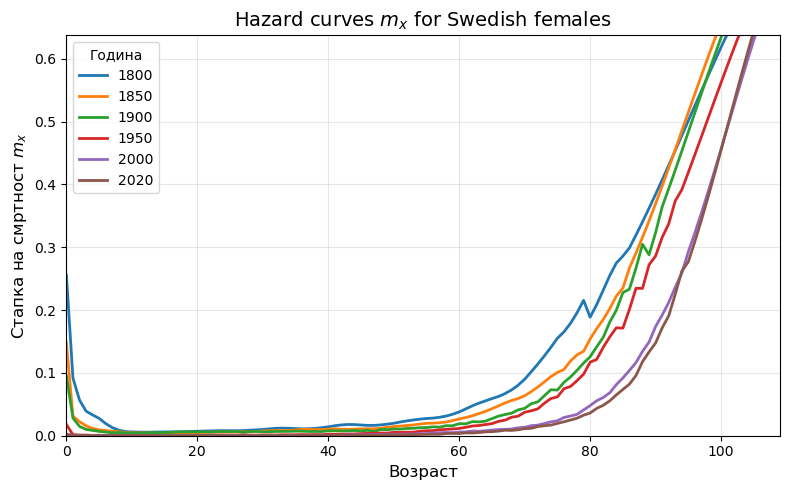

In [79]:
plot_hazard_curves(
    df_swed_both[df_swed_both["Sex"]=="Male"],
    years_sel,
    "Hazard curves $m_x$ for Swedish males",
    "sweden_hazard_males.png"
)

plot_hazard_curves(
    df_swed_both[df_swed_both["Sex"]=="Female"],
    years_sel,
    "Hazard curves $m_x$ for Swedish females",
    "sweden_hazard_females.png"
)

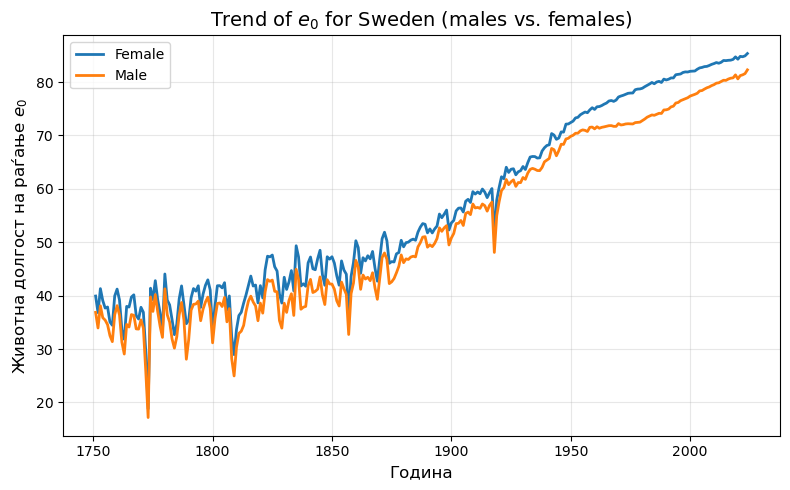

In [81]:
male_e0 = (
    df_swed_both[df_swed_both["Sex"]=="Male"]
    .query("Age == 0")
    .dropna(subset=["ex"])
    .groupby("Year")["ex"]
    .first()
    .reset_index()
    .assign(Sex="Male")
)

female_e0 = (
    df_swed_both[df_swed_both["Sex"]=="Female"]
    .query("Age == 0")
    .dropna(subset=["ex"])
    .groupby("Year")["ex"]
    .first()
    .reset_index()
    .assign(Sex="Female")
)

e0_both = pd.concat([male_e0, female_e0], ignore_index=True)

plt.figure(figsize=(8,5))
for sex, df_sex in e0_both.groupby("Sex"):
    plt.plot(
        df_sex["Year"],
        df_sex["ex"],
        label=sex,
        linewidth=2
    )
plt.xlabel("Година", fontsize=12)
plt.ylabel("Животна долгост на раѓање $e_0$", fontsize=12)
plt.title("Trend of $e_0$ for Sweden (males vs. females)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("sweden_e0_trend_m_vs_f.png")
plt.show()

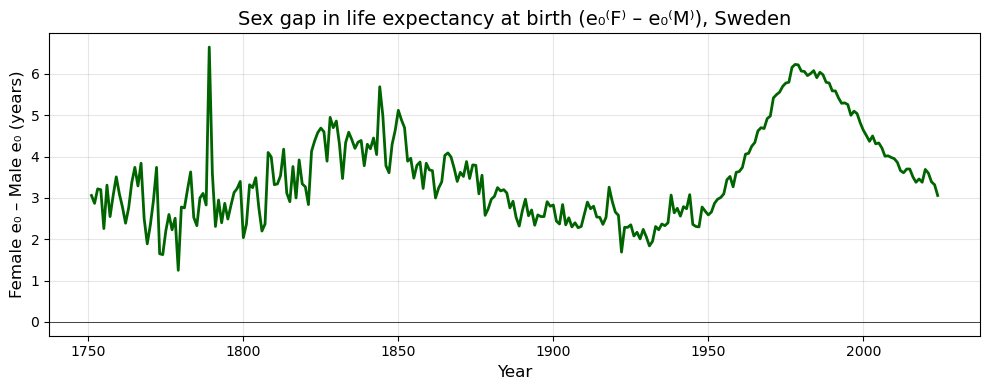

In [83]:
male_e0 = (
    df_swed_both.query("Sex=='Male' & Age==0")
    [["Year","ex"]]
    .rename(columns={"ex":"e0"})
)
female_e0 = (
    df_swed_both.query("Sex=='Female' & Age==0")
    [["Year","ex"]]
    .rename(columns={"ex":"e0"})
)

gap = (
    male_e0.merge(female_e0, on="Year", suffixes=("_M","_F"))
    .assign(delta_e0=lambda df: df["e0_F"] - df["e0_M"])
    .sort_values("Year")
)

# line plot of Δ e0
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(gap["Year"], gap["delta_e0"], color="darkgreen", linewidth=2)
plt.axhline(0, color="k", linewidth=0.5)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Female e₀ – Male e₀ (years)", fontsize=12)
plt.title("Sex gap in life expectancy at birth (e₀⁽F⁾ – e₀⁽M⁾), Sweden", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("sex_gap.png")
plt.show()

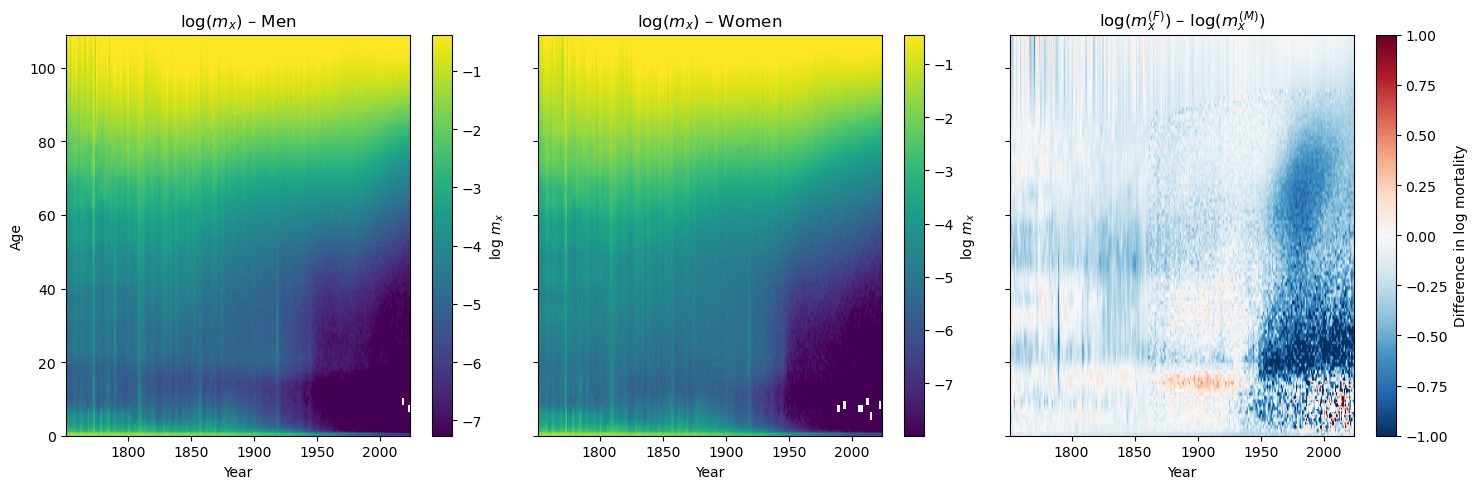

In [85]:

# keep only rows where mx > 0, Age < 110
df_clean = df_swed_both.query("Age < 110 & mx > 0").copy()

# pivot: Year × Age → log(mx)
pivot_m          = df_clean.query("Sex=='Male'")\
    .pivot(index="Age", columns="Year", values="mx")
pivot_f          = df_clean.query("Sex=='Female'")\
    .pivot(index="Age", columns="Year", values="mx")

log_m_male       = np.log(pivot_m)
log_m_female     = np.log(pivot_f)

# 2.2 Difference surface (female – male)
# Only keep overlapping Years & Ages
common_years     = log_m_male.columns.intersection(log_m_female.columns)
common_ages      = log_m_male.index.intersection(log_m_female.index)

diff_surface = (
    log_m_female.loc[common_ages, common_years]
    - log_m_male.loc[common_ages, common_years]
)

# 2.3 Plotting (heat‐maps) with imshow or pcolormesh
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5),
                         sharey=True)

# (a) Male log(mx)
ax = axes[0]
im = ax.imshow(
    np.flipud(log_m_male.loc[common_ages, common_years].values),
    aspect="auto",
    cmap="viridis",
    vmin=np.nanpercentile(log_m_male, 5),
    vmax=np.nanpercentile(log_m_male, 95),
    extent=[common_years.min(), common_years.max(), 
            common_ages.min(), common_ages.max()]
)
ax.set_title("log($m_x$) – Men")
ax.set_xlabel("Year")
ax.set_ylabel("Age")
fig.colorbar(im, ax=ax, label="log $m_x$")

# (b) Female log(mx)
ax = axes[1]
im = ax.imshow(
    np.flipud(log_m_female.loc[common_ages, common_years].values),
    aspect="auto",
    cmap="viridis",
    vmin=np.nanpercentile(log_m_female, 5),
    vmax=np.nanpercentile(log_m_female, 95),
    extent=[common_years.min(), common_years.max(), 
            common_ages.min(), common_ages.max()]
)
ax.set_title("log($m_x$) – Women")
ax.set_xlabel("Year")
# no ylabel, share with left
fig.colorbar(im, ax=ax, label="log $m_x$")

# (c) Difference (Female – Male)
ax = axes[2]
im = ax.imshow(
    np.flipud(diff_surface.values),
    aspect="auto",
    cmap="RdBu_r",
    vmin=-1.0, vmax=1.0,    # center near zero
    extent=[common_years.min(), common_years.max(), 
            common_ages.min(), common_ages.max()]
)
ax.set_title("log($m_x^{(F)}$) – log($m_x^{(M)}$)")
ax.set_xlabel("Year")
fig.colorbar(im, ax=ax, label="Difference in log mortality")
plt.tight_layout()
plt.savefig("log_mortality_f_and_m.png")
plt.show()

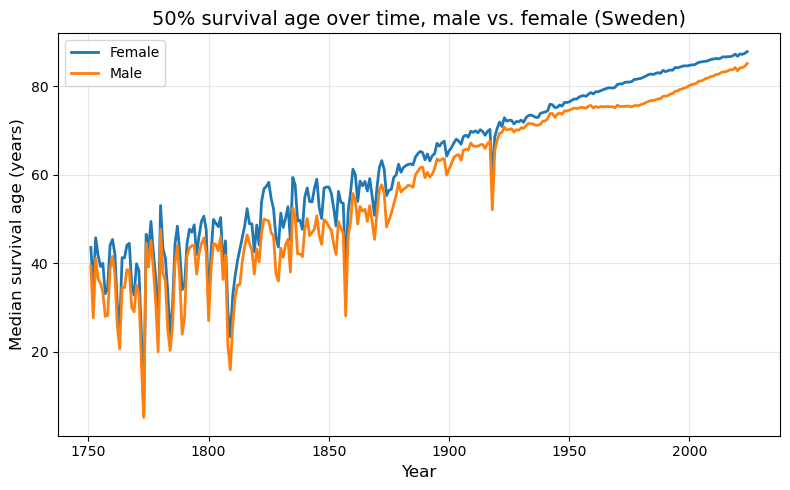

In [87]:
# 4.1 Helper to find median age: for each Year & Sex, invert lx, this is done with MUCH MORE help from chatgpt :)
medians = []
for (sex, year), group in df_swed_both.groupby(["Sex","Year"]):
    sub = group.sort_values("Age").reset_index(drop=True)
    # Normalize ℓ_x by ℓ₀
    l0 = sub.loc[sub["Age"] == 0, "lx"].iloc[0]
    sub["lx_frac"] = sub["lx"] / l0
    # Interpolate to find age where lx_frac crosses 0.5
    if sub["lx_frac"].max() < 0.5:
        # if even ℓ₀ < 0.5 (very high infant mortality?), skip
        continue
    ages = sub["Age"].values
    surv = sub["lx_frac"].values
    # Simple linear interpolation: find first index where surv <= 0.5
    idx = np.where(surv <= 0.5)[0]
    if len(idx)==0:
        median_age = np.nan
    else:
        i = idx[0]
        if i == 0:
            median_age = ages[0]
        else:
            # linear interpolation between (ages[i-1], surv[i-1]) and (ages[i], surv[i])
            x0, y0 = ages[i-1], surv[i-1]
            x1, y1 = ages[i], surv[i]
            median_age = x0 + (0.5 - y0)*(x1-x0)/(y1-y0)
    medians.append({"Sex":sex, "Year":year, "median_age": median_age})

df_median = pd.DataFrame(medians).dropna().sort_values(["Sex","Year"])

plt.figure(figsize=(8,5))
for sex, df_sex in df_median.groupby("Sex"):
    plt.plot(df_sex["Year"], df_sex["median_age"], label=sex, linewidth=2)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Median survival age (years)", fontsize=12)
plt.title("50% survival age over time, male vs. female (Sweden)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

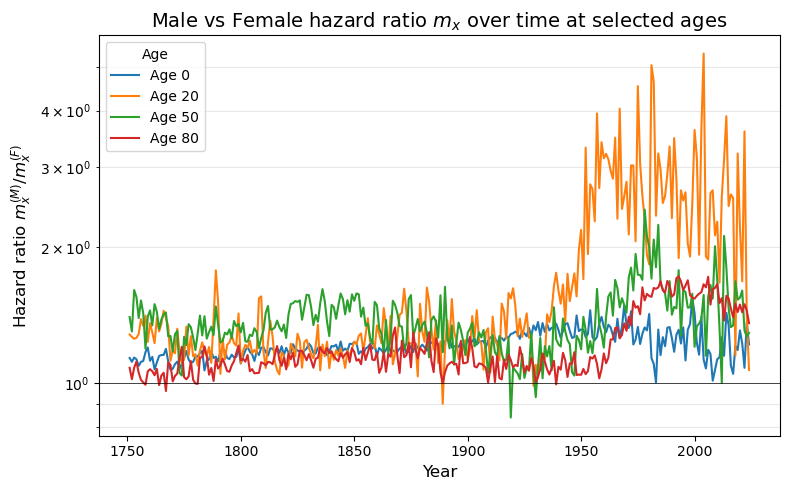

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


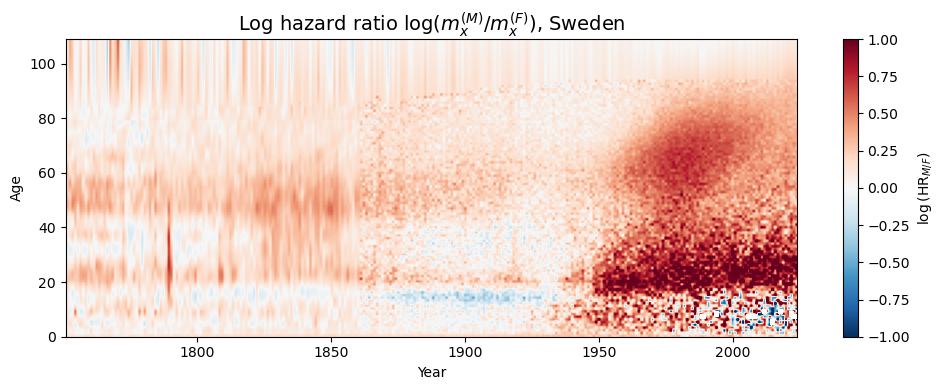

In [89]:
# build a df of hazard ratio: Male mx / Female mx
df_mx = df_swed_both.pivot_table(
    index=["Year","Age"], columns="Sex", values="mx"
).reset_index()

df_mx["HR_M_by_F"] = df_mx["Male"] / df_mx["Female"]

# (a) Plot time‐series of HR at certain ages
ages_to_plot = [0, 20, 50, 80]
plt.figure(figsize=(8,5))
for age in ages_to_plot:
    df_age = df_mx[df_mx["Age"] == age].dropna(subset=["HR_M_by_F"])
    plt.plot(df_age["Year"], df_age["HR_M_by_F"], label=f"Age {age}")

plt.axhline(1.0, color="k", linewidth=0.5)
plt.yscale("log")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Hazard ratio $m_x^{(M)}/m_x^{(F)}$", fontsize=12)
plt.title("Male vs Female hazard ratio $m_x$ over time at selected ages", fontsize=14)
plt.legend(title="Age")
plt.grid(alpha=0.3, which="both", axis="y")
plt.tight_layout()
plt.show()

# (b) Heat‐map of log(HR) across Age × Year
hr_pivot = df_mx.pivot(index="Age", columns="Year", values="HR_M_by_F")
log_hr    = np.log(hr_pivot)

plt.figure(figsize=(10,4))
plt.imshow(
    np.flipud(log_hr.values),
    aspect="auto",
    cmap="RdBu_r",
    vmin=-1.0, vmax=1.0,   # center around 0 (log HR=0 => HR=1)
    extent=[log_hr.columns.min(), log_hr.columns.max(),
            log_hr.index.min(),   log_hr.index.max()]
)
plt.colorbar(label="log (HR$_{M/F}$)")
plt.xlabel("Year")
plt.ylabel("Age")
plt.title("Log hazard ratio log($m_x^{(M)}/m_x^{(F)}$), Sweden", fontsize=14)
plt.tight_layout()
plt.savefig("log_hazard.png")
plt.show()

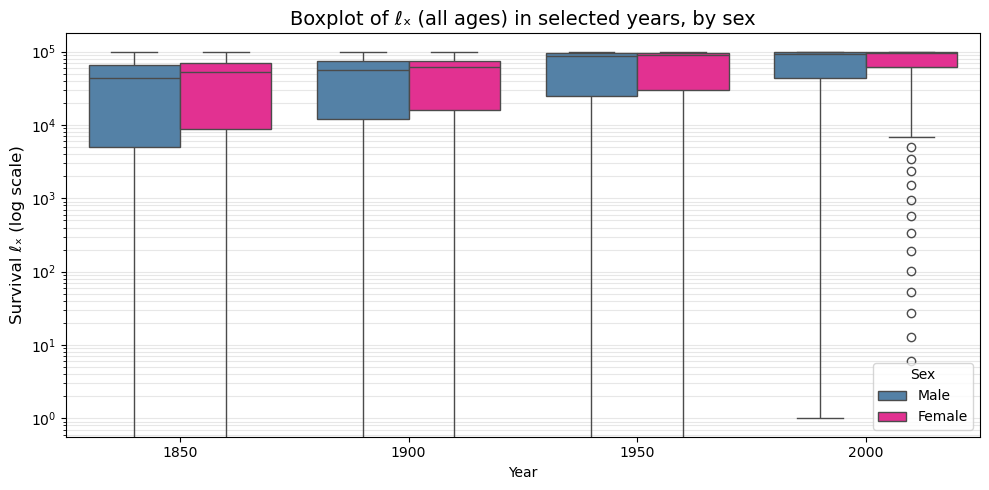

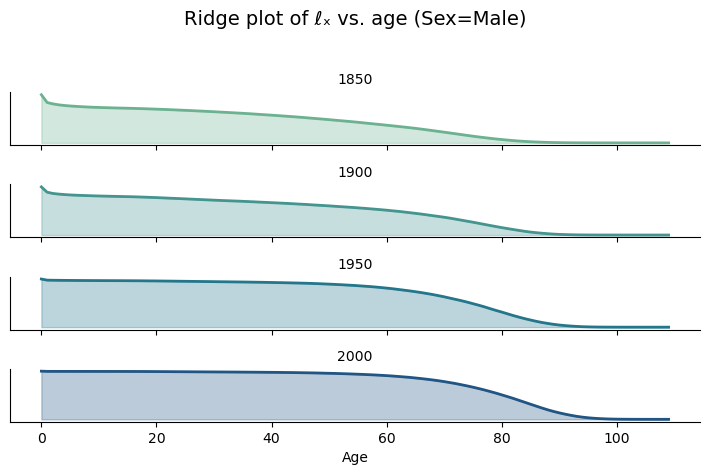

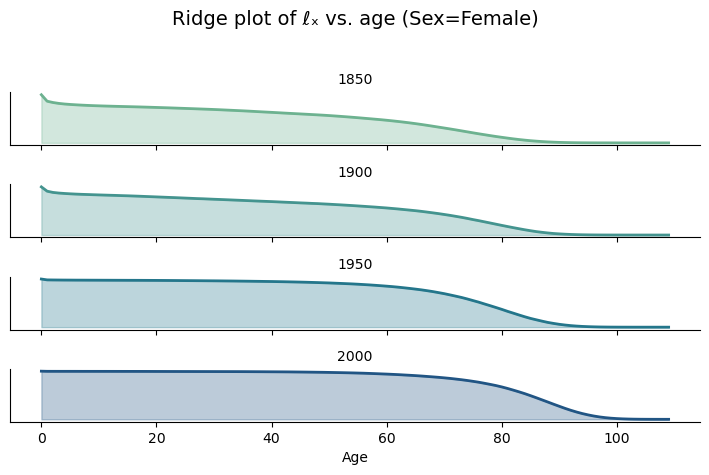

In [91]:
import seaborn as sns

# df of (Year, Sex, Age, lx)
df_lx = df_swed_both[["Year","Sex","Age","lx"]].dropna()

# samo odredeni godini
years_sel = [1850, 1900, 1950, 2000]
df_sample = df_lx[df_lx["Year"].isin(years_sel)].copy()

# boxplot of ℓₓ distributions (side by side: male vs female) for each Year
plt.figure(figsize=(10,5))
sns.boxplot(
    data=df_sample,
    x="Year", y="lx", hue="Sex",
    palette={"Male":"steelblue","Female":"deeppink"}
)
plt.yscale("log")
plt.ylabel("Survival ℓₓ (log scale)", fontsize=12)
plt.title("Boxplot of ℓₓ (all ages) in selected years, by sex", fontsize=14)
plt.grid(alpha=0.3, axis="y", which="both")
plt.tight_layout()
plt.show()

#  ridge‐plot of ℓₓ vs. Age across years, for one sex
for sex in ["Male","Female"]:
    df_sex = df_sample[df_sample["Sex"] == sex]
    g = sns.FacetGrid(df_sex, row="Year", hue="Year", aspect=6, height=1.2, palette="crest")
    g.map(plt.plot, "Age", "lx", clip_on=False, linewidth=2)
    g.map(plt.fill_between, "Age", "lx", alpha=0.3)
    g.fig.subplots_adjust(hspace=-0.4)
    g.set_titles(row_template="{row_name}")
    g.set(yticks=[], ylabel="")
    g.set_xlabels("Age")
    g.fig.suptitle(f"Ridge plot of ℓₓ vs. age (Sex={sex})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Od tuka nadole e samo kako primer za da mi tekne da prasham shto mozhe da se napravi za povekje drzhavi

In [63]:
df_sweden = pd.read_fwf(
    'datasets/sweden_bltper_1x1.csv',
    skiprows=2, 
    names=['Year','Age','mx','qx','ax','lx','dx','Lx','Tx','ex']
)
df_usa = pd.read_fwf(
    'datasets/usa_bltper_1x1.csv',
    skiprows=2, 
    names=['Year','Age','mx','qx','ax','lx','dx','Lx','Tx','ex']
)
df_japan = pd.read_fwf(
    'datasets/japan_bltper_1x1.csv',
    skiprows=2, 
    names=['Year','Age','mx','qx','ax','lx','dx','Lx','Tx','ex']
)
df_italy = pd.read_fwf(
    'datasets/italy_bltper_1x1.csv',
    skiprows=2, 
    names=['Year','Age','mx','qx','ax','lx','dx','Lx','Tx','ex']
)
df_russia = pd.read_fwf(
    'datasets/russia_bltper_1x1.csv',
    skiprows=2, 
    names=['Year','Age','mx','qx','ax','lx','dx','Lx','Tx','ex']
)

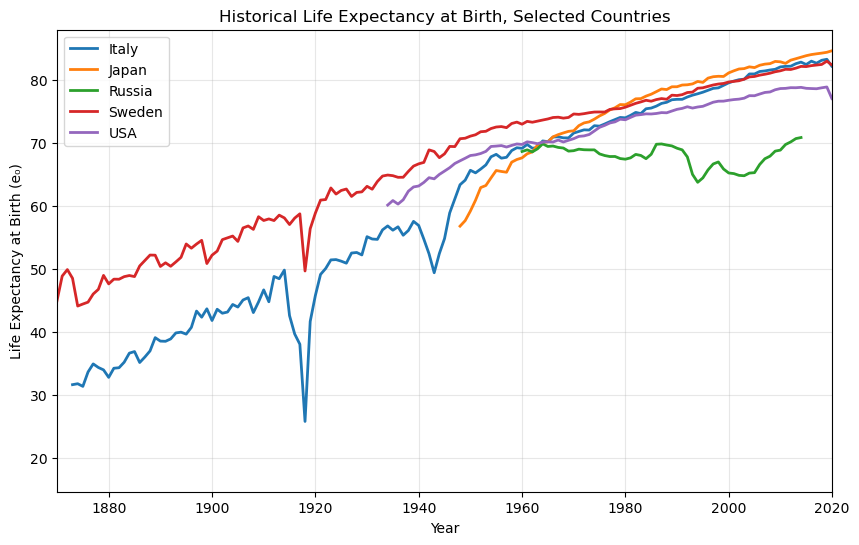

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

def extract_life_expectancy_at_birth(df):
    if (df['Age'] == 0).any():
        return df[df['Age'] == 0][['Year','ex']].rename(columns={'ex':'e0'})
    else:
        tmp = df[df['Age'] == 1][['Year','ex']].copy()
        tmp.rename(columns={'ex':'e0'}, inplace=True)
        return tmp

italy_e0  = extract_life_expectancy_at_birth(df_italy)
japan_e0  = extract_life_expectancy_at_birth(df_japan)
russia_e0 = extract_life_expectancy_at_birth(df_russia)
sweden_e0 = extract_life_expectancy_at_birth(df_sweden)
usa_e0    = extract_life_expectancy_at_birth(df_usa)

plt.figure(figsize=(10,6))
plt.plot(italy_e0['Year'],  italy_e0['e0'],  label='Italy',  linewidth=2)
plt.plot(japan_e0['Year'],  japan_e0['e0'],  label='Japan',  linewidth=2)
plt.plot(russia_e0['Year'], russia_e0['e0'], label='Russia', linewidth=2)
plt.plot(sweden_e0['Year'], sweden_e0['e0'], label='Sweden', linewidth=2)
plt.plot(usa_e0['Year'],    usa_e0['e0'],    label='USA',    linewidth=2)

plt.xlabel("Year")
plt.ylabel("Life Expectancy at Birth (e₀)")
plt.title("Historical Life Expectancy at Birth, Selected Countries")
plt.legend()
plt.grid(alpha=0.3)

plt.xlim(1870, 2020)
plt.savefig("drzhavi.png")
plt.show()


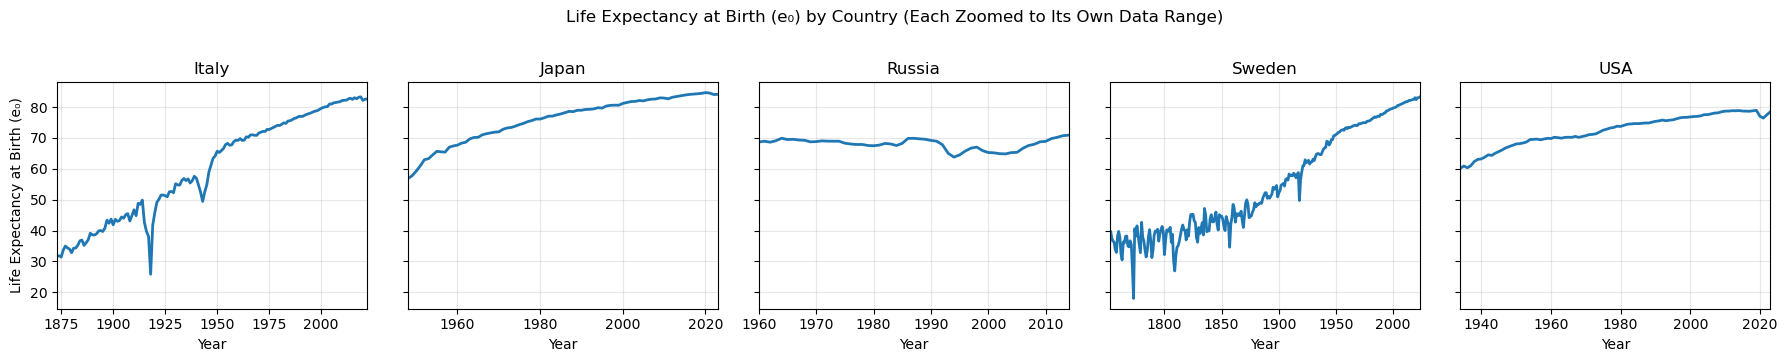

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

def extract_life_expectancy_at_birth(df):
    if (df['Age'] == 0).any():
        return df.loc[df['Age'] == 0, ['Year','ex']].rename(columns={'ex':'e0'})
    else:
        tmp = df.loc[df['Age'] == 1, ['Year','ex']].copy()
        tmp.rename(columns={'ex':'e0'}, inplace=True)
        return tmp

italy_e0  = extract_life_expectancy_at_birth(df_italy)
japan_e0  = extract_life_expectancy_at_birth(df_japan)
russia_e0 = extract_life_expectancy_at_birth(df_russia)
sweden_e0 = extract_life_expectancy_at_birth(df_sweden)
usa_e0    = extract_life_expectancy_at_birth(df_usa)

country_curves = {
    'Italy':  italy_e0,
    'Japan':  japan_e0,
    'Russia': russia_e0,
    'Sweden': sweden_e0,
    'USA':    usa_e0
}

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 3.5), sharey=True)

for ax, (country, df_e0) in zip(axes, country_curves.items()):
    ax.plot(df_e0['Year'], df_e0['e0'], color='C0', linewidth=2)
    ax.set_title(country)
    ax.set_xlabel("Year")
    if country == 'Italy':
        ax.set_ylabel("Life Expectancy at Birth (e₀)")
    min_yr = df_e0['Year'].min()
    max_yr = df_e0['Year'].max()
    ax.set_xlim(min_yr, max_yr)
    ax.grid(alpha=0.3)

plt.suptitle("Life Expectancy at Birth (e₀) by Country (Each Zoomed to Its Own Data Range)", y=1.02)
plt.tight_layout()
plt.show()
